In [1]:
from PlumeNet import *
import glob
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [6]:
flist = glob.glob('augmented_labelled_data/pos_labeller_1/*npz')
# print(len(flist))
diag = [1]*len(flist)

import random
_flist = glob.glob('augmented_labelled_data/neg_labeller_1/*npz')
random.shuffle(_flist)
print(len(flist), len(_flist))

flist += _flist
diag += [0]*len(_flist)

filedf = pd.DataFrame({"path" : flist, "diag": diag}).sample(frac=1).reset_index(drop=True)
filedf.to_csv('train_data_clean.csv')

1449 2505


In [8]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs, log_dir):
    """
    Function to plot history of loss function in training
    """
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.savefig(log_dir+'%s_training.jpg'%model_name)

In [18]:
# Split into training, validation, and test data sets
from sklearn.model_selection import train_test_split
subdf, _ = train_test_split(df, stratify=df.diag, test_size=0.50)  # 10% val

samplediff = subdf[subdf['diag'] == 0].shape[0] - subdf[subdf['diag'] == 1].shape[0]
subdf = subdf.drop(subdf[subdf['diag'] == 0].sample(n=samplediff).index)

725 1252
725 725


Hyper params now:
Model name : PlumeNet_0

Learning rate : 0.00015318066247284882

Batch size : 14

Number of epoch : 34

Pos samples:  725
Neg samples:  725
Train: (1232, 3) 
Val: (218, 3)
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs
PlumeNet_0
Epoch [0]
Mean loss on train: 0.953431986272335 
Mean DICE on train: 0.3051316341096855 
Mean DICE on validation: 0.5483457051600634
Epoch [1]
Mean loss on train: 0.48021490025249397 
Mean DICE on train: 0.6060479436962062 
Mean DICE on validation: 0.693582209515946
Epoch [2]
Mean loss on train: 0.3370851830325343 
Mean DICE on train: 0.7148643296964861 
Mean DICE on validation: 0.6786580387951613
Epoch [3]
Mean loss on train: 0.29620436138727446 
Mean DICE on train: 0.746352753948322 
Mean DICE on validation: 0.7124135430336042
Epoch [4]
Mean loss on train: 0.23731488226489586 
Mean DICE on train: 0.7951419997357227 
Mean DICE on validation: 0.7380941777778335
Epoch [5]
Mean loss on train: 0.2162270558659326 
Mean DICE o

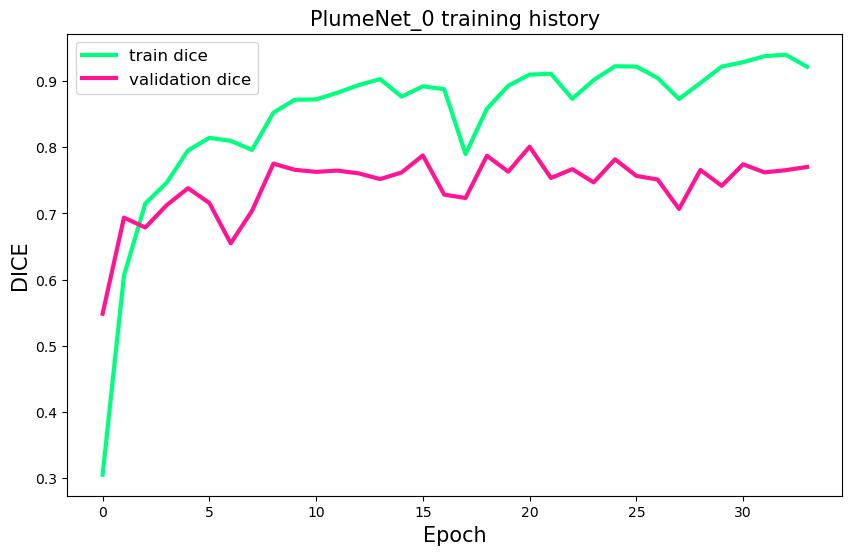

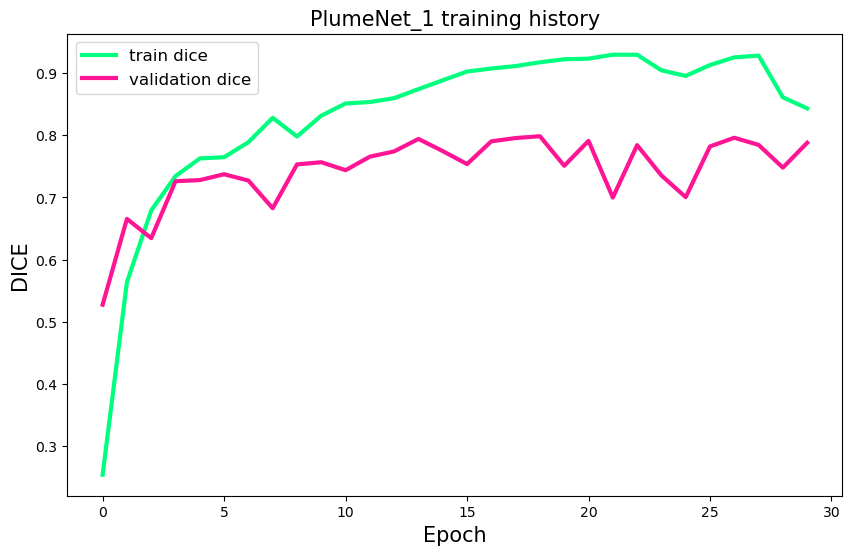

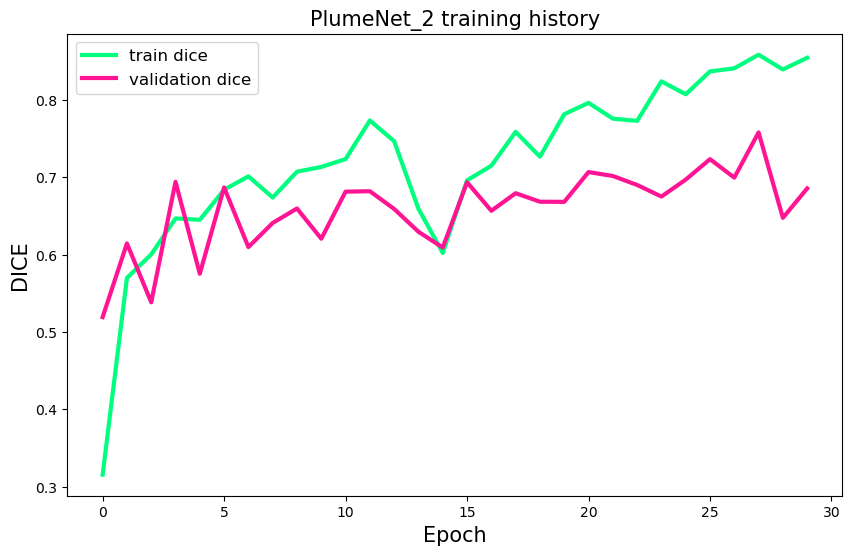

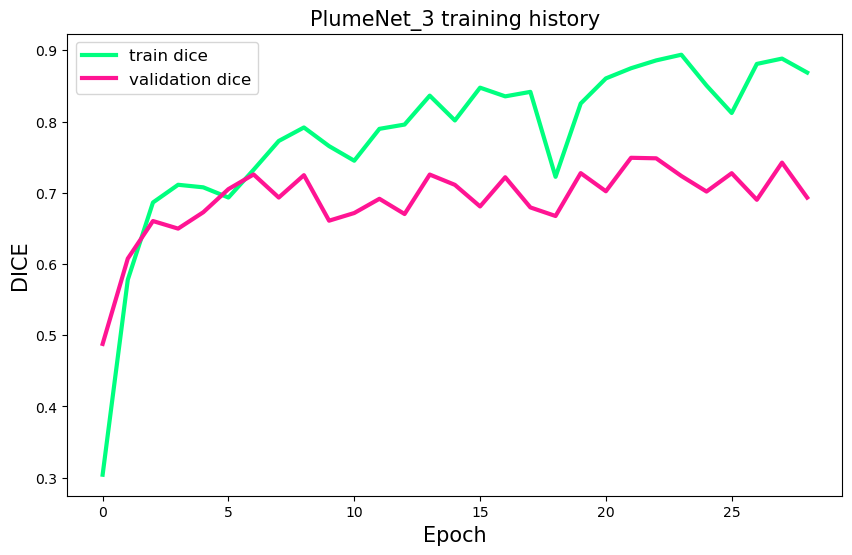

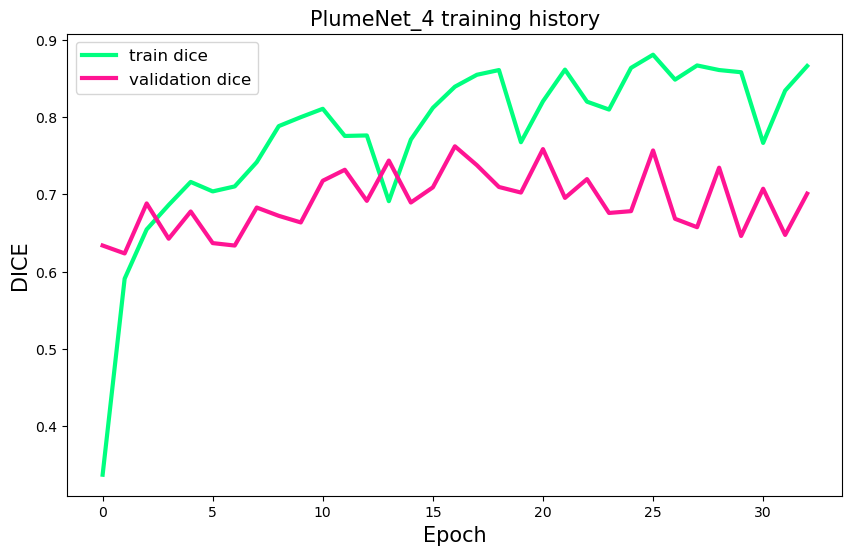

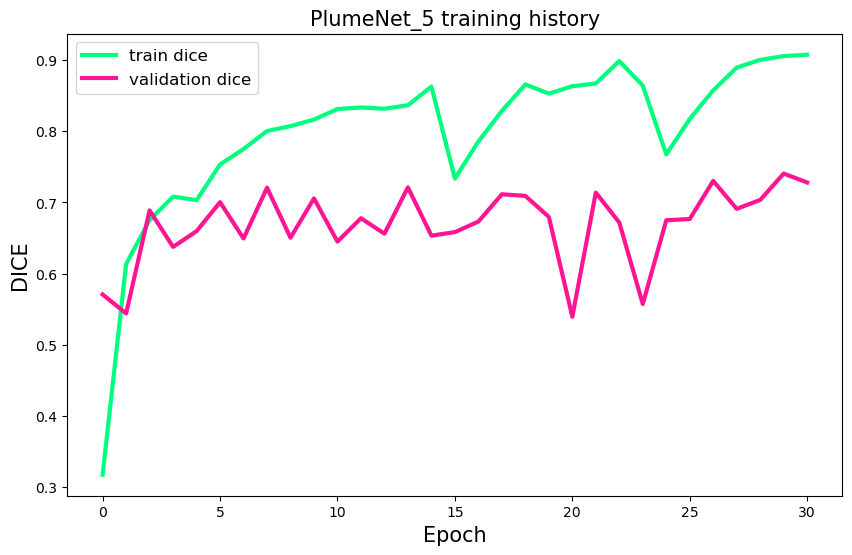

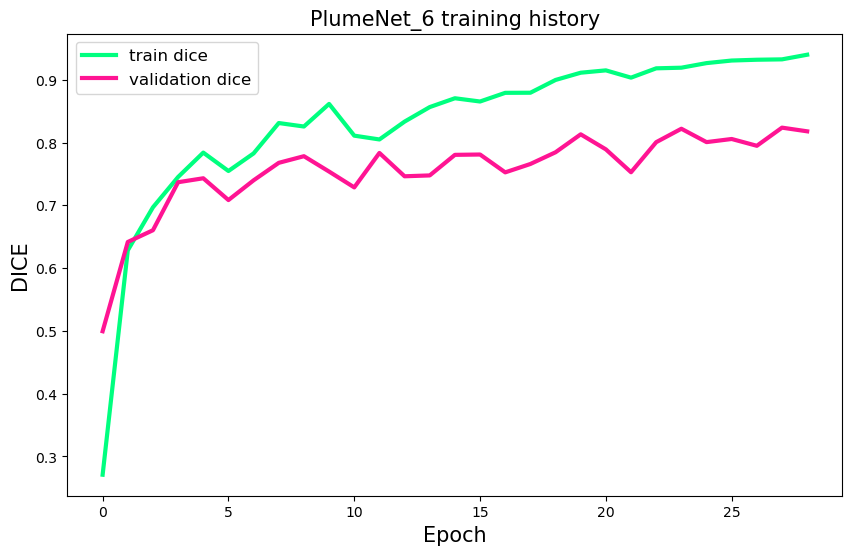

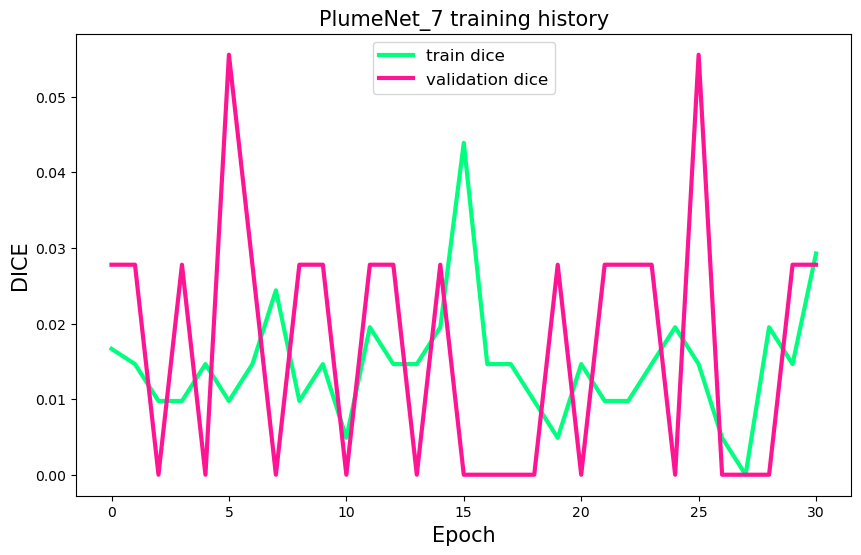

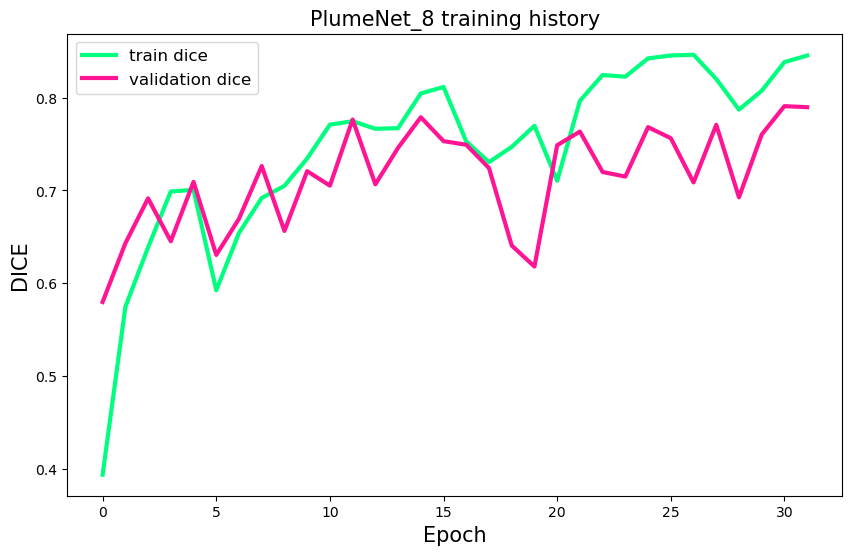

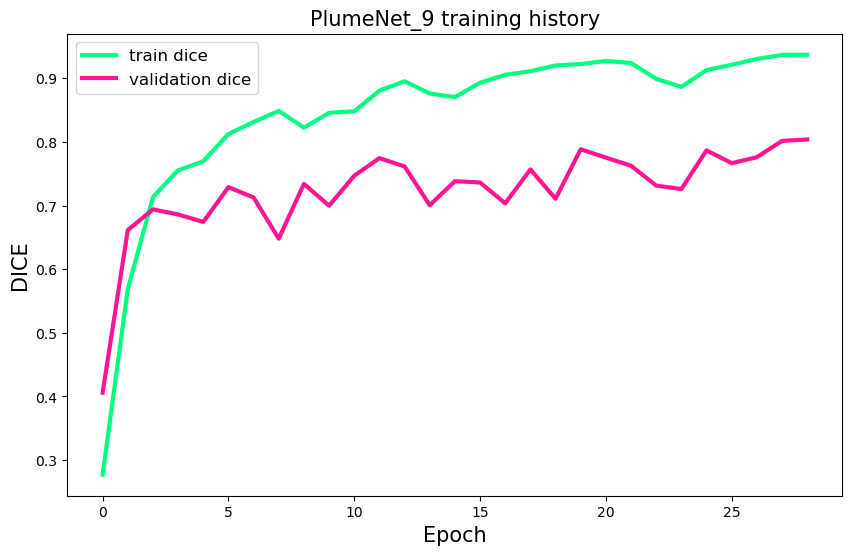

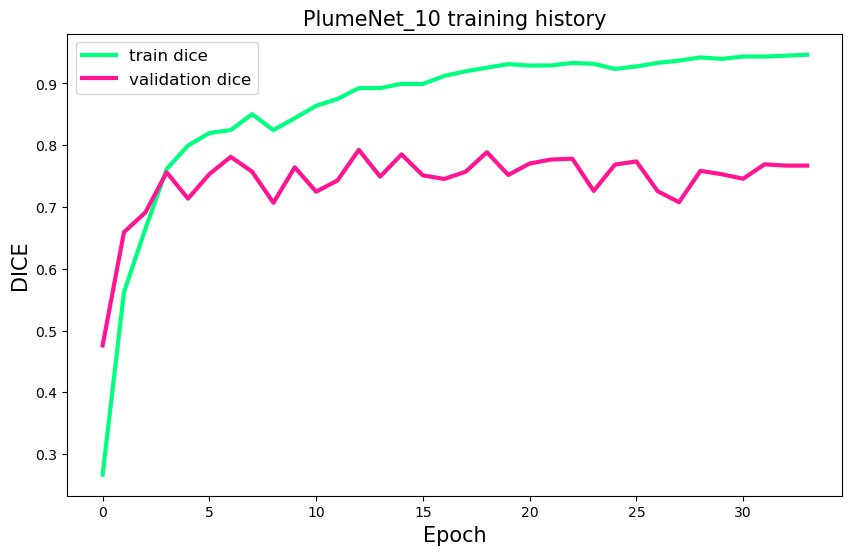

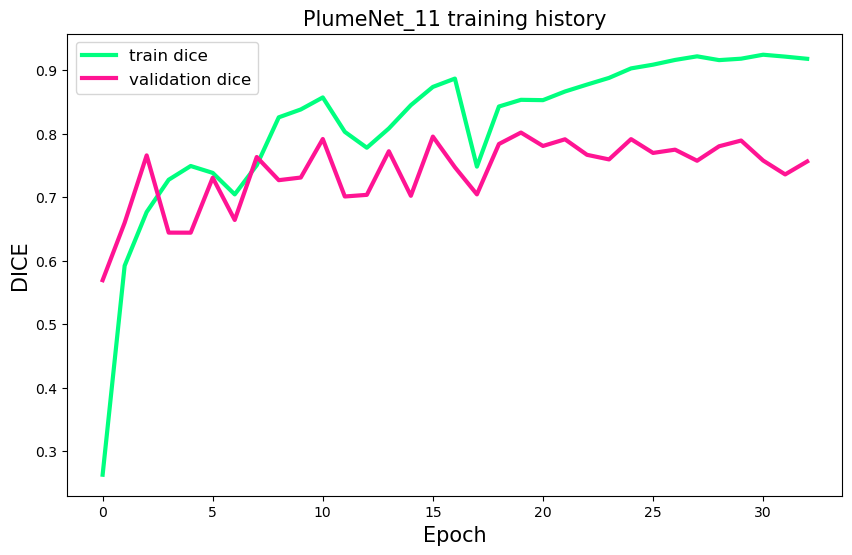

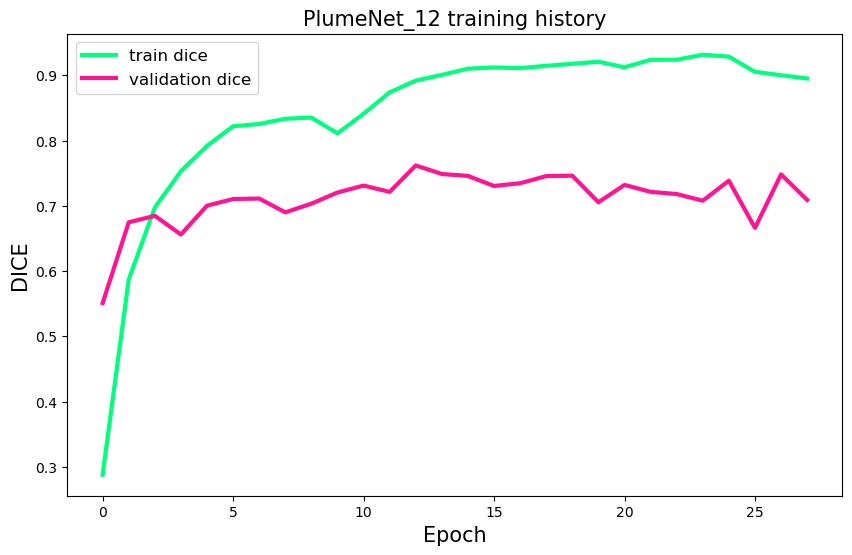

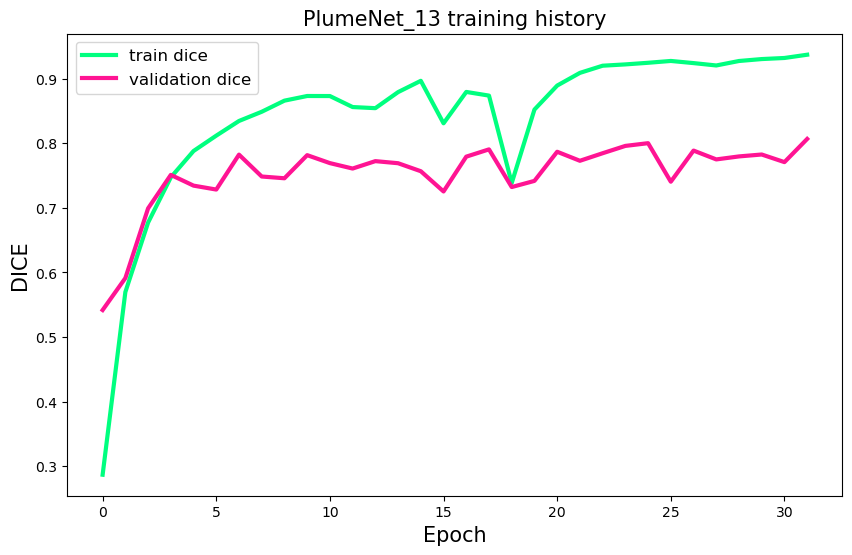

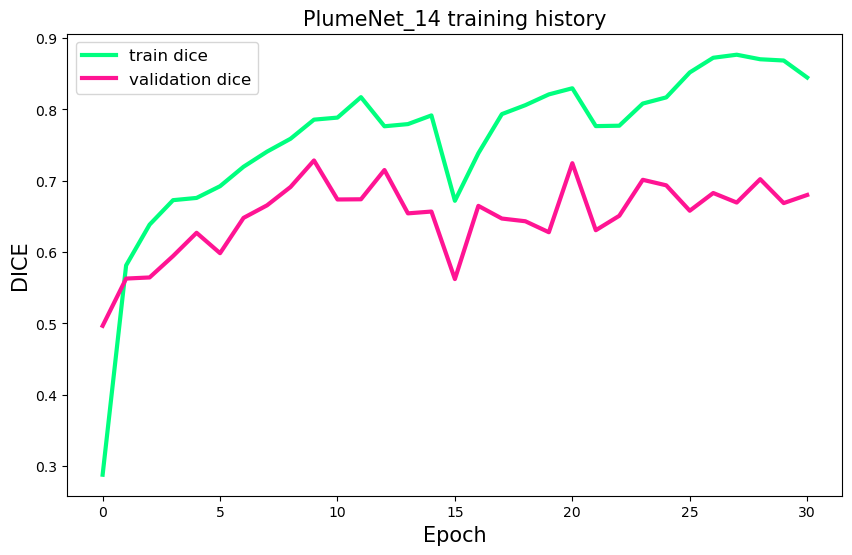

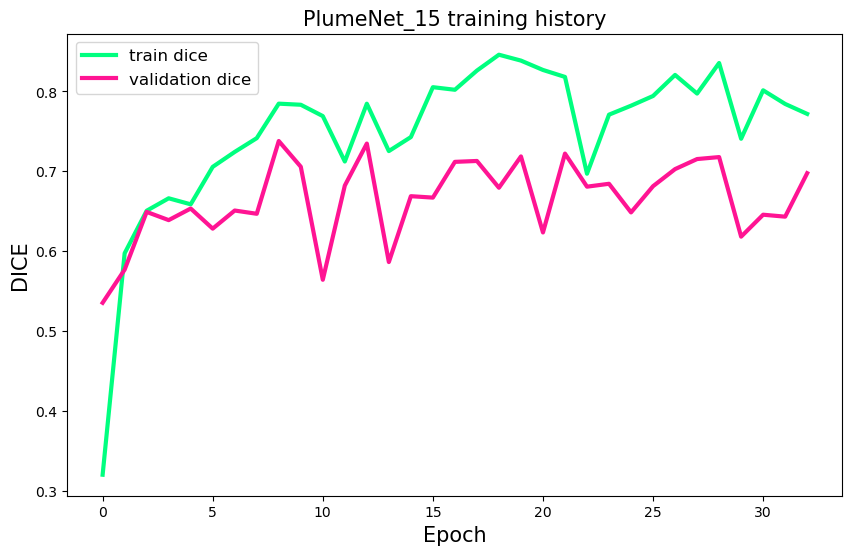

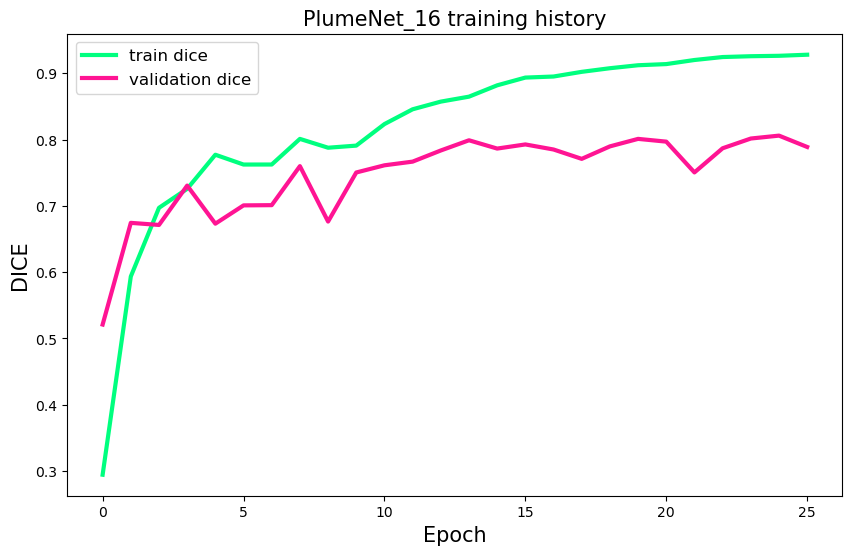

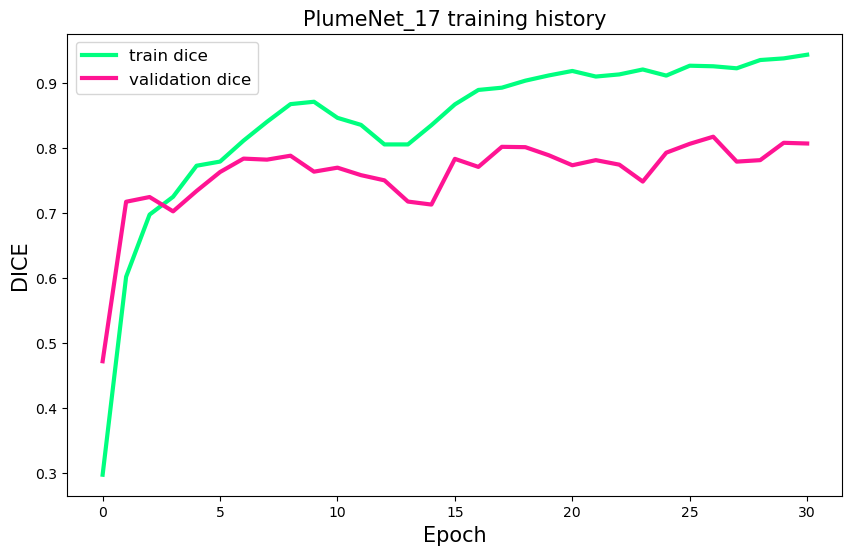

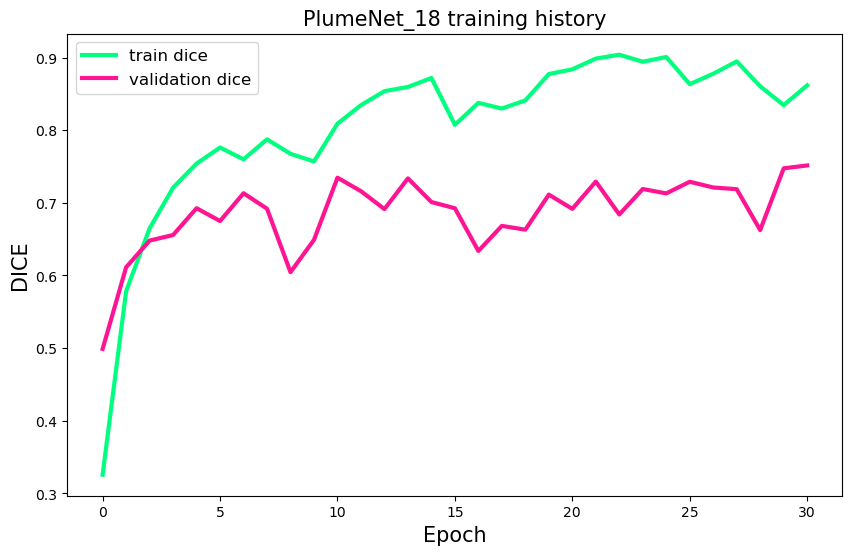

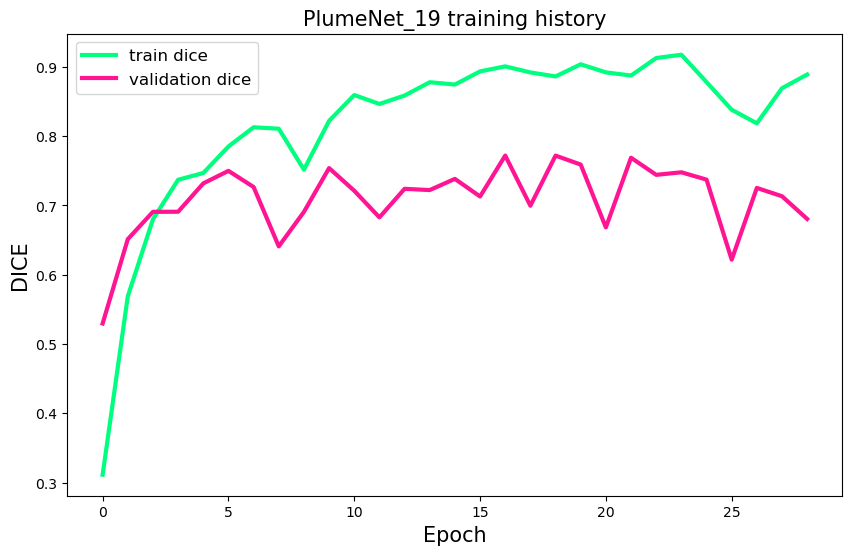

In [20]:
from sklearn.model_selection import train_test_split

# directory to save training logs and final model weights
log_dir = 'training_logs/'

for member in range(0, 20):

    modelname = "PlumeNet_%d"%member
    # Split df into train_df and val_df, p:1449, n:2505
    subdf, _ = train_test_split(df, stratify=df.diag, test_size=0.50)  # 10% val
    samplediff = subdf[subdf['diag'] == 0].shape[0] - subdf[subdf['diag'] == 1].shape[0]
    subdf = subdf.drop(subdf[subdf['diag'] == 0].sample(n=samplediff).index)

    lrnow = np.random.uniform(8e-5, 2e-4)
    batchnow = int(np.random.uniform(5, 15))
    num_ep = int(np.random.uniform(25, 35))

    _params = {
        'Model name': modelname,
        'Learning rate': lrnow,
        'Batch size': batchnow,
        'Number of epoch': num_ep,
    }
    print('Hyper params now:')
    print('======================')
    _fh = open(log_dir+modelname + '_hyper_params.txt','w')
    for key in _params.keys():
        print(key + ' : ' + str(_params[key]) + "\n")
        _fh.write(key + ' : ' + str(_params[key]) + "\n")
    _fh.close()
    print('======================')


    # Split train_df into train_df and val_df
    train_df, val_df = train_test_split(subdf, stratify=subdf.diag, test_size=0.15) 
    train_df = train_df.reset_index(drop=True)
    val_df  = val_df.reset_index(drop=True)

    print('Pos samples: ', subdf[subdf['diag'] == 1].shape[0])
    print('Neg samples: ', subdf[subdf['diag'] == 0].shape[0])
    print(f"Train: {train_df.shape} \nVal: {val_df.shape}") # \nTest: {val_df.shape}

    # train
    train_dataset = PlumeDataset(df=train_df)
    train_dataloader = DataLoader(train_dataset, batch_size=batchnow, num_workers=4, shuffle=True)

    # val
    val_dataset = PlumeDataset(df=val_df)
    val_dataloader = DataLoader(val_dataset, batch_size=batchnow, num_workers=4, shuffle=True)


    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    pnet_model = PlumeNet(6, 1, n_classes=1).to(device)
    # output = pnet_model(torch.randn(1,6,128,128).to(device))
    # print(output.shape)
    
    %time                                                                                               
    # Train ResNeXt50
    pnet_optimizer = torch.optim.Adam(pnet_model.parameters(), lr=lrnow)
    pnet_lh, pnet_th, pnet_vh = train_model(modelname, pnet_model, train_dataloader, val_dataloader, bce_dice_loss, pnet_optimizer, num_ep)


    torch.save(pnet_model.state_dict(), log_dir+'%s_weights.h5'%modelname)
    np.savez(log_dir+'%s_history.npz'%modelname, loss=pnet_lh, train=pnet_th, valid=pnet_vh)
    plot_model_history("%s training history"%modelname, pnet_th, pnet_vh, num_ep, log_dir)